<a href="https://colab.research.google.com/github/willow788/Text-Conditioned-Image-Synthesis/blob/main/Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install diffusers transformers accelerate torch torchvision

In [15]:
from diffusers import StableDiffusionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16 if device == "cuda" else torch.float32)
pipeline = pipeline.to(device)

Using device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

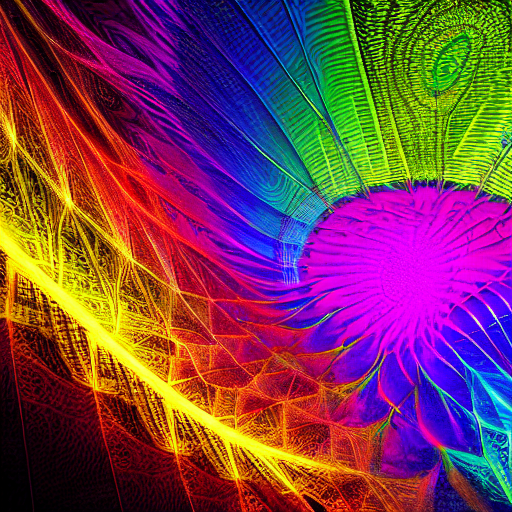

In [ ]:
prompt = "abstract neon fractal art, highly detailed, 4k"
image = pipeline(prompt).images[0]
image

In [ ]:
#add a learning loop
!pip install sentence-transformers

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NEW BEST SCORE: 0.206537663936615


  0%|          | 0/50 [00:00<?, ?it/s]

NEW BEST SCORE: 0.24003244936466217


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

NEW BEST SCORE: 0.24838213622570038


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

NEW BEST SCORE: 0.2503940463066101


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

NEW BEST SCORE: 0.2553535997867584


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


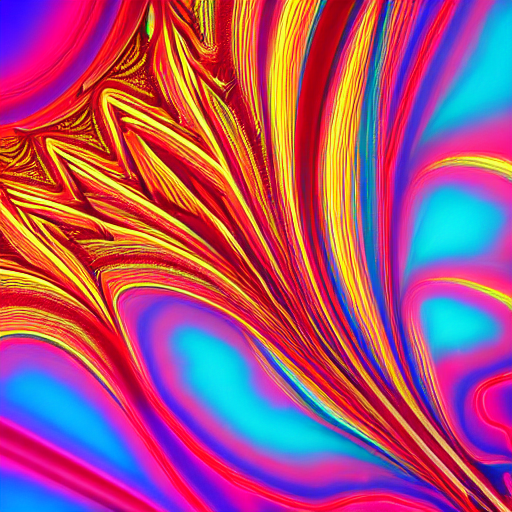

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer("clip-ViT-B-32")
#loaded the model
target_propmt = "dreamlike glowy pink colored artwork"

def scoring_image(image):
  image_being_embedded = model.encode(image, convert_to_tensor=True)
  target_embedding = model.encode(target_propmt, convert_to_tensor=True)
#here we are converting image prompt to vector for the model to understand

  return util.cos_sim(image_being_embedded, target_embedding).item()

#main loop
best_image = None
best_score = -1 # Initialize with a very low score to ensure the first image is accepted

for step in range(20):
  image = pipeline(prompt).images[0]
  score = scoring_image(image) # Call the scoring_image function correctly

  if score > best_score:
    best_score = score
    best_image = image
    print("NEW BEST SCORE:", best_score)

# Display the best image after the loop finishes
best_image

In [ ]:
#saving the best image
best_image.save("best_image.png")

In [ ]:
!pip install gradio

In [1]:
import gradio as gr
from diffusers import StableDiffusionPipeline
import torch
from sentence_transformers import SentenceTransformer, util
import random

# Define device globally
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define a list of potential style and descriptive modifiers globally
style_modifiers = [
    'cinematic lighting', 'vivid colors', 'pastel palette', 'monochromatic',
    'sharp focus', 'soft lighting', 'dreamlike', 'futuristic', 'vintage',
    'abstract', 'photorealistic', 'watercolor painting', 'oil on canvas',
    'digital art', 'surreal', 'minimalist', 'intricate details',
    'glowing effect', 'highly detailed', '4k resolution', '8k resolution',
    'award winning', 'trending on artstation', 'octane render', 'unreal engine',
    'ray tracing'
]

print(f"Defined {len(style_modifiers)} style modifiers.")

def augment_prompt(base_prompt: str) -> str:
  """
  Augments a base prompt by adding 1 to 3 random style and descriptive modifiers.

  Args:
      base_prompt (str): The initial prompt provided by the user.

  Returns:
      str: An augmented prompt with additional modifiers.
  """
  num_modifiers = random.randint(1, 3)
  chosen_modifiers = random.sample(style_modifiers, num_modifiers)
  augmented_prompt = f"{base_prompt}, {', '.join(chosen_modifiers)}" # Corrected join character
  return augmented_prompt

# Load stable diffusion model globally, outside of any function that will be called repeatedly
if device == "cuda":
    pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipeline.enable_model_cpu_offload() # Use offload for memory management
else:
    pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32)
    pipeline.to(device)

# Load CLIP model globally
clip_model = SentenceTransformer("clip-ViT-B-32")

def score_image(image, target_text):
  image_embedding = clip_model.encode(image, convert_to_tensor=True)
  target_embedding = clip_model.encode(target_text, convert_to_tensor=True)

  return util.cos_sim(image_embedding, target_embedding).item()

def generate_and_score_image(user_prompt, target_style_description, num_samples):
  best_image = None
  best_score = -1

  for i in range(int(num_samples)):
    current_prompt = augment_prompt(user_prompt)
    print(f"Generating with augmented prompt: '{current_prompt}'")
    new_image = pipeline(current_prompt).images[0]
    score = score_image(new_image, target_style_description)

    if score > best_score:
      best_score = score
      best_image = new_image
      print(f"New best score: {best_score:.4f}")

  return best_image, f"Best score: {best_score:.4f}"

# Gradio interface definition should be at the global scope
with gr.Blocks() as demo:
    gr.Markdown("## AI learns how to make art with Prompt Augmentation")
    prompt_input = gr.Textbox(label="Base Image Prompt") # Corrected to gr.Textbox
    target_input = gr.Textbox(label="Target Style Description (for scoring)") # Corrected to gr.Textbox
    samples_slider = gr.Slider(1, 10, value=3, step=1, label="Images to generate per round (each with an augmented prompt)")

    button = gr.Button("Generate and find the best image")

    output_image = gr.Image()
    output_text1 = gr.Textbox(label="Result")
    # Removed output_text2 as it was for 'style modifiers' which is handled in the print statements
    # and the function only returns two values.

    button.click(generate_and_score_image,
                 inputs=[prompt_input, target_input, samples_slider],
                 outputs=[output_image, output_text1]) # Removed output_text2

demo.launch()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Defined 26 style modifiers.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a489905f9ac325ec8a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
